In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from math import ceil
plt.style.use('dark_background')

In [2]:
np.random.seed(18)
N = 1000
d = 2
n_classes = 5
stdev = 6
X = np.zeros((N, d))
mus = np.random.randint(1, 100, size=(n_classes, 2)).astype(np.float64)
mus 

array([[43., 20.],
       [70., 63.],
       [50., 47.],
       [67.,  9.],
       [25., 99.]])

In [3]:
space = N//n_classes
c = []
for i in range(n_classes):
    X[i*space:(i+1)*space] = np.random.randn(space, d)*stdev + mus[i]
    c += [i]*space

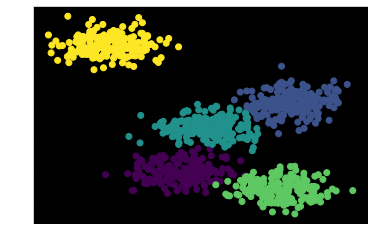

In [4]:
plt.scatter(X[:,0], X[:,1], c=c)

In [5]:
def plotter(ret, cols=2):
    n_rows = ceil(len(ret)/cols)
    if n_rows > 1:
        fig, axes = plt.subplots(n_rows, cols)
        ret_i = 0
        for i in range(n_rows):
            for j in range(cols):
                if ret_i >= len(ret):
                    break
                labels, cost = ret[ret_i]
                axes[i, j].scatter(X[:,0], X[:,1], c=labels)
                axes[i, j].title.set_text(f"cost={cost}")
                ret_i += 1

        fig.set_figwidth(20)
        fig.set_figheight(12)

    elif n_rows == 0:
        fig, axes = plt.subplots(n_rows, cols)
        for i, ax in enumerate(axes):
            labels, cost = ret[i]
            ax.scatter(X[:,0], X[:,1], c=labels)
            ax.title.set_text(f"cost={cost}")
        fig.set_figwidth(20)
        
    else:
        raise ValueError("Something weird happened")

In [6]:
def euclidean(X, mus):
    """Calculates euclidean distance beteen points in cluster and each mean in mus.

    Args:
        X ((N,2) array): points to calculate distance from
        mus ((k, 2) array): mus to calculate distance from

    Returns:
        (N, k): distance from each mean in mus
    """
    return np.vstack([np.linalg.norm(X - a, axis=1) for a in mus]).T

In [7]:
def kmus(X, k=3, max_iterations=3):
    N, dim = X.shape
    ret = []
    mus = X[np.random.choice(N, size=(k,), replace=False)]

    for i in range(max_iterations):
        dists = euclidean(X, mus)
        labels = np.argmin(dists, axis=1)
        j = np.sum(dists)

        if len(ret) > 0 and (ret[-1][0] == labels).all():
            print(f"EARLY STOP AT {i}, max_iterations={max_iterations}", flush=True)
            break
        
        ret.append((labels, j))
        for j in range(k):
            mus[j] = X[np.where(np.argmin(dists, axis=1)==j)].mean(axis=0)
    
    plotter(ret)
        

EARLY STOP AT 5, max_iterations=30


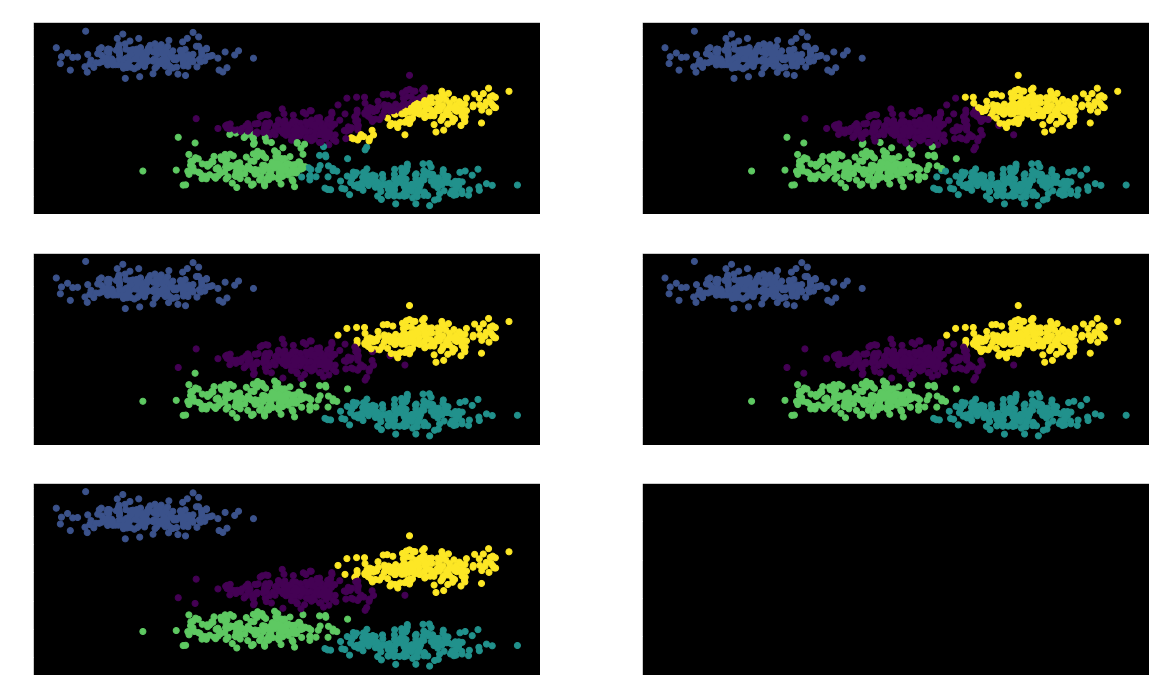

In [8]:
kmus(X, k=n_classes, max_iterations=30)

In [9]:
def soft_kmus(X, k=3, max_iterations=3, beta=1.0):
    N, dim = X.shape
    ret = []
    mus = X[np.random.choice(N, size=(k,), replace=False)]

    for i in range(max_iterations):
        dists = euclidean(X, mus) # Nxk
        exps = np.exp(-beta*dists) # Nxk
        r = exps/np.sum(exps, axis=1, keepdims=True) # Nxk
        labels = np.argmin(dists, axis=1) # N
        j = np.sum(dists)

        if len(ret) > 0 and (ret[-1][0] == labels).all():
            print(f"EARLY STOP AT {i}, max_iterations={max_iterations}", flush=True)
            break
        
        ret.append((labels, j))
        for j in range(k):
            mus[j] = r[:,j].dot(X)/np.sum(r[:,j]) 
    
    plotter(ret)
        

EARLY STOP AT 5, max_iterations=30


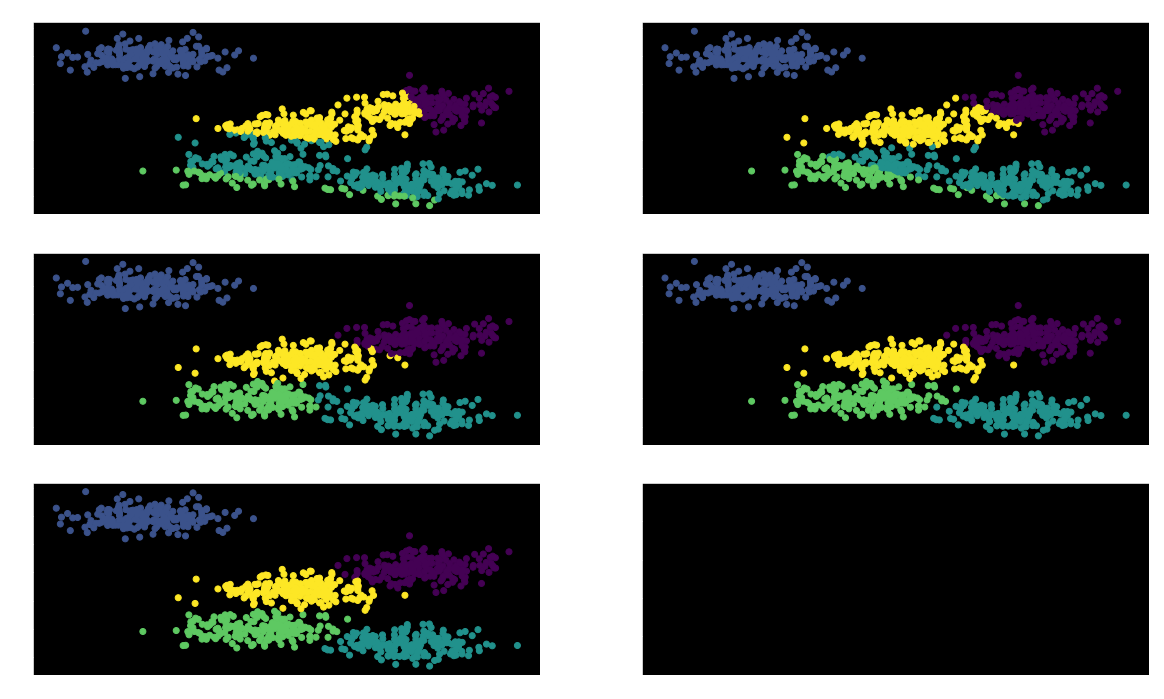

In [10]:
soft_kmus(X, k=n_classes, max_iterations=30)

In [48]:
def gamma(X, mus, pis, covs):
    N, dim = X.shape
    k, dim = mus.shape
    gammas = np.zeros((N, k))
    for j in range(k):
        mu, pi, cov = mus[j], pis[j], covs[j]
        gammas[:, j] = pi*multivariate_normal.pdf(X, mu, cov)
    return gammas / gammas.sum(axis=1, keepdims=True) # Nxk

def gmm(X, k=3, max_iterations=3, smoothing=1e-2):
    N, dim = X.shape

    pis = np.ones(k)/k # k
    covs = np.array([np.eye(dim) for _ in range(k)]) # kxdimxdim
    mus = X[np.random.choice(N, size=(k,), replace=False)] # kxdim
    
    ret = []

    for i in range(max_iterations):
        gammas = gamma(X, mus, pis, covs)
         
        dists = euclidean(X, mus)
        labels = np.argmin(dists, axis=1)
        j = np.sum(dists)

        if len(ret) > 0 and (ret[-1][0] == labels).all():
            print(f"EARLY STOP AT {i}, max_iterations={max_iterations}", flush=True)
            break
        
        ret.append((labels, j))
        for j in range(k):
            Nk = gammas[:,j].sum()
            mus[j] = gammas[:,j].dot(X) / Nk # 1xN * Nxdim
            delta = X - mus[j]
            Rdelta = gammas[:, j].reshape(N, 1) * delta
            covs[j] = Rdelta.T.dot(delta) / Nk + np.eye(dim)*smoothing # dimx1 * 1xdim
            pis[j] = Nk / N
            
        
    plotter(ret)

In [49]:
gmm(X, k=n_classes, max_iterations=30)

/var/folders/n6/sg58ff6s3pq_ptf4yx4y4znw0000gn/T/ipykernel_73345/2493599997.py:8: RuntimeWarning: invalid value encountered in divide
  return gammas / gammas.sum(axis=1, keepdims=True) # Nxk


ValueError: array must not contain infs or NaNs